In [1]:
import numpy as np
import pandas as pd
import time, os, nltk
from functools import reduce

from matplotlib import pyplot as plt

from keras.layers import Embedding
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
plt.rcParams["figure.figsize"] = (30, 10)

## If you are using google colabs use following code for downloading dataset from kaggle

## Download glove embeddings & use it to create embedding layer matrix

In [3]:
embeddings_index = {}

f = open(os.path.join("embeddings", "glove.6B", "glove.6B.100d.txt"))

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [4]:
embeddings_index["india"]

array([-0.95967  ,  0.30795  ,  0.90052  ,  1.0364   ,  0.0034906,
       -0.80758  , -1.139    ,  0.81109  , -0.67857  ,  0.52609  ,
       -0.072252 , -0.75613  ,  0.52847  ,  1.0927   , -0.51895  ,
       -0.21335  ,  0.18184  ,  0.40038  , -0.6547   ,  0.34626  ,
        0.92248  , -0.25001  ,  1.1779   ,  0.61006  ,  0.029763 ,
        0.4378   ,  0.53647  ,  0.68827  ,  0.14582  , -0.27446  ,
       -0.50289  ,  1.0366   , -0.29851  , -0.32927  ,  0.24944  ,
       -0.33779  ,  0.0083236, -0.21373  , -0.45898  , -0.23441  ,
       -1.2958   ,  0.74799  ,  0.78192  , -0.75644  ,  0.84375  ,
       -0.51725  ,  1.0952   ,  0.51768  ,  0.27906  , -0.033519 ,
       -0.1573   ,  0.7396   ,  0.39775  ,  1.132    , -0.69279  ,
       -2.0093   , -1.1731   , -0.14204  ,  1.5658   , -0.097956 ,
       -0.071165 , -0.18906  ,  0.037441 ,  0.48037  ,  0.29248  ,
        0.9216   ,  0.33285  ,  0.30963  ,  1.1272   ,  0.19965  ,
        0.47058  ,  0.019022 , -0.27432  , -0.49782  , -0.2944

In [5]:
embeddings_index["PAD"] = np.zeros(100, dtype='float32')
embeddings_index["UNK"] = np.zeros(100, dtype='float32')

In [6]:
embeddings_index["PAD"]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [7]:
word2idx = {}
idx2word = {}

counter = 0
for word, _ in embeddings_index.items():
    word2idx[word] = counter
    idx2word[counter] = word
    
    counter += 1

In [8]:
word2idx["the"]

0

In [9]:
idx2word[0]

'the'

In [10]:
embeddings_index["the"]

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

In [11]:
embeddings_index[idx2word[0]]

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

In [12]:
word2idx["PAD"], word2idx["UNK"]

(400000, 400001)

In [13]:
idx2word[400000], idx2word[400001]

('PAD', 'UNK')

In [14]:
embeddings_index["PAD"]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [15]:
embeddings_index[idx2word[400000]]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [16]:
embeddings_index["UNK"]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [17]:
embeddings_index[idx2word[400001]]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [18]:
EMBEDDING_DIM = 100

In [19]:
embedding_matrix = np.zeros((len(embeddings_index), EMBEDDING_DIM))

In [20]:
embedding_matrix.shape

(400002, 100)

In [21]:
for word, index in word2idx.items():
    
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[index] = embedding_vector

In [22]:
embedding_matrix[0]

array([-0.038194  , -0.24487001,  0.72812003, -0.39961001,  0.083172  ,
        0.043953  , -0.39140999,  0.3344    , -0.57545   ,  0.087459  ,
        0.28786999, -0.06731   ,  0.30906001, -0.26383999, -0.13231   ,
       -0.20757   ,  0.33395001, -0.33848   , -0.31742999, -0.48335999,
        0.1464    , -0.37303999,  0.34577   ,  0.052041  ,  0.44946   ,
       -0.46970999,  0.02628   , -0.54154998, -0.15518001, -0.14106999,
       -0.039722  ,  0.28277001,  0.14393   ,  0.23464   , -0.31020999,
        0.086173  ,  0.20397   ,  0.52623999,  0.17163999, -0.082378  ,
       -0.71787   , -0.41531   ,  0.20334999, -0.12763   ,  0.41367   ,
        0.55186999,  0.57907999, -0.33476999, -0.36559001, -0.54856998,
       -0.062892  ,  0.26583999,  0.30204999,  0.99774998, -0.80480999,
       -3.0243001 ,  0.01254   , -0.36941999,  2.21670008,  0.72201002,
       -0.24978   ,  0.92136002,  0.034514  ,  0.46744999,  1.10790002,
       -0.19358   , -0.074575  ,  0.23353   , -0.052062  , -0.22

In [23]:
embedding_matrix[474]

array([-0.95967001,  0.30794999,  0.90052003,  1.03639996,  0.0034906 ,
       -0.80757999, -1.13900006,  0.81108999, -0.67856997,  0.52609003,
       -0.072252  , -0.75612998,  0.52846998,  1.0927    , -0.51894999,
       -0.21335   ,  0.18184   ,  0.40037999, -0.65469998,  0.34626001,
        0.92247999, -0.25001001,  1.17789996,  0.61005998,  0.029763  ,
        0.43779999,  0.53647   ,  0.68826997,  0.14582001, -0.27445999,
       -0.50288999,  1.03659999, -0.29850999, -0.32927001,  0.24944   ,
       -0.33779001,  0.0083236 , -0.21373001, -0.45897999, -0.23441   ,
       -1.29579997,  0.74799001,  0.78192002, -0.75643998,  0.84375   ,
       -0.51725   ,  1.09519994,  0.51767999,  0.27906001, -0.033519  ,
       -0.1573    ,  0.7396    ,  0.39774999,  1.13199997, -0.69278997,
       -2.00929999, -1.17309999, -0.14204   ,  1.56579995, -0.097956  ,
       -0.071165  , -0.18906   ,  0.037441  ,  0.48036999,  0.29247999,
        0.92159998,  0.33285001,  0.30963001,  1.12720001,  0.19

## If you are using local machine follow following steps

In [24]:
print("Already exists") if os.path.isdir("data/") else os.mkdir("data/")

folder_path = "data/"

Already exists


In [25]:
print("Already exists") if os.path.isdir(folder_path + "train/") else os.mkdir(folder_path + "train/")
print("Already exists") if os.path.isdir(folder_path + "test/") else os.mkdir(folder_path + "test/")

Already exists
Already exists


In [26]:
# Collect all positive review files
pos_files = os.listdir(folder_path + "train/pos/")

In [27]:
print(pos_files[:10])

['0_9.txt', '10000_8.txt', '10001_10.txt', '10002_7.txt', '10003_8.txt', '10004_8.txt', '10005_7.txt', '10006_7.txt', '10007_7.txt', '10008_7.txt']


In [28]:
# Collect all negative review files
neg_files = os.listdir(folder_path + "train/neg/")

In [29]:
print(neg_files[:10])

['0_3.txt', '10000_4.txt', '10001_4.txt', '10002_1.txt', '10003_1.txt', '10004_3.txt', '10005_3.txt', '10006_4.txt', '10007_1.txt', '10008_2.txt']


In [30]:
# Total number of files positive & negative i.e. equals to total number of reviews
print(len(pos_files), len(neg_files))

12500 12500


In [31]:
# Put all text data inside X & label data inside Y
X = []
Y = [] # positive = 1 & negative = 0

In [32]:
# Download tokenizer 'punket' of nltk library
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/swapnilpote/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [33]:
# Read all positive reviews & put inside X & it's respective label inside Y
for file in pos_files:
    with open(folder_path + "train/pos/" + file, "r") as f:
        sentence = f.readline().lower()
        tokens = nltk.word_tokenize(sentence)
        X.append(tokens)
        Y.append(1)

In [34]:
# Length X, Y
len(X), len(Y)

(12500, 12500)

In [35]:
print(X[:2])

[['bromwell', 'high', 'is', 'a', 'cartoon', 'comedy', '.', 'it', 'ran', 'at', 'the', 'same', 'time', 'as', 'some', 'other', 'programs', 'about', 'school', 'life', ',', 'such', 'as', '``', 'teachers', "''", '.', 'my', '35', 'years', 'in', 'the', 'teaching', 'profession', 'lead', 'me', 'to', 'believe', 'that', 'bromwell', 'high', "'s", 'satire', 'is', 'much', 'closer', 'to', 'reality', 'than', 'is', '``', 'teachers', "''", '.', 'the', 'scramble', 'to', 'survive', 'financially', ',', 'the', 'insightful', 'students', 'who', 'can', 'see', 'right', 'through', 'their', 'pathetic', 'teachers', "'", 'pomp', ',', 'the', 'pettiness', 'of', 'the', 'whole', 'situation', ',', 'all', 'remind', 'me', 'of', 'the', 'schools', 'i', 'knew', 'and', 'their', 'students', '.', 'when', 'i', 'saw', 'the', 'episode', 'in', 'which', 'a', 'student', 'repeatedly', 'tried', 'to', 'burn', 'down', 'the', 'school', ',', 'i', 'immediately', 'recalled', '...', '...', '...', 'at', '...', '...', '...', '.', 'high', '.', 'a

In [36]:
# Read all negative reviews & put inside X & it's respective label inside Y
for file in neg_files:
    with open(folder_path + "train/neg/" + file, "r") as f:
        sentence = f.readline().lower()
        tokens = nltk.word_tokenize(sentence)
        X.append(tokens)
        Y.append(0)

In [37]:
# Length X, Y
len(X), len(Y)

(25000, 25000)

In [38]:
# Put data inside pandas dataframe for some analysis
dataset = pd.DataFrame({"Sentence": X, "Label": Y})

In [39]:
# print top 10 sentences
dataset.head(10)

,Sentence,Label
0,"[bromwell, high, is, a, cartoon, comedy, ., it...",1
1,"[homelessness, (, or, houselessness, as, georg...",1
2,"[brilliant, over-acting, by, lesley, ann, warr...",1
3,"[this, is, easily, the, most, underrated, film...",1
4,"[this, is, not, the, typical, mel, brooks, fil...",1
5,"[this, is, n't, the, comedic, robin, williams,...",1
6,"[yes, its, an, art, ..., to, successfully, mak...",1
7,"[in, this, ``, critically, acclaimed, psycholo...",1
8,"[the, night, listener, (, 2006, ), **1/2, robi...",1
9,"[you, know, ,, robin, williams, ,, god, bless,...",1


In [40]:
# print bottom 10 sentences
dataset.tail(10)

,Sentence,Label
24990,"[yeti, :, curse, of, the, snow, demon, starts,...",0
24991,"[hmmm, ,, a, sports, team, is, in, a, plane, c...",0
24992,"[i, saw, this, piece, of, garbage, on, amc, la...",0
24993,"[although, the, production, and, jerry, jameso...",0
24994,"[capt, ., gallagher, (, lemmon, ), and, flight...",0
24995,"[towards, the, end, of, the, movie, ,, i, felt...",0
24996,"[this, is, the, kind, of, movie, that, my, ene...",0
24997,"[i, saw, 'descent, ', last, night, at, the, st...",0
24998,"[some, films, that, you, pick, up, for, a, pou...",0
24999,"[this, is, one, of, the, dumbest, films, ,, i,...",0


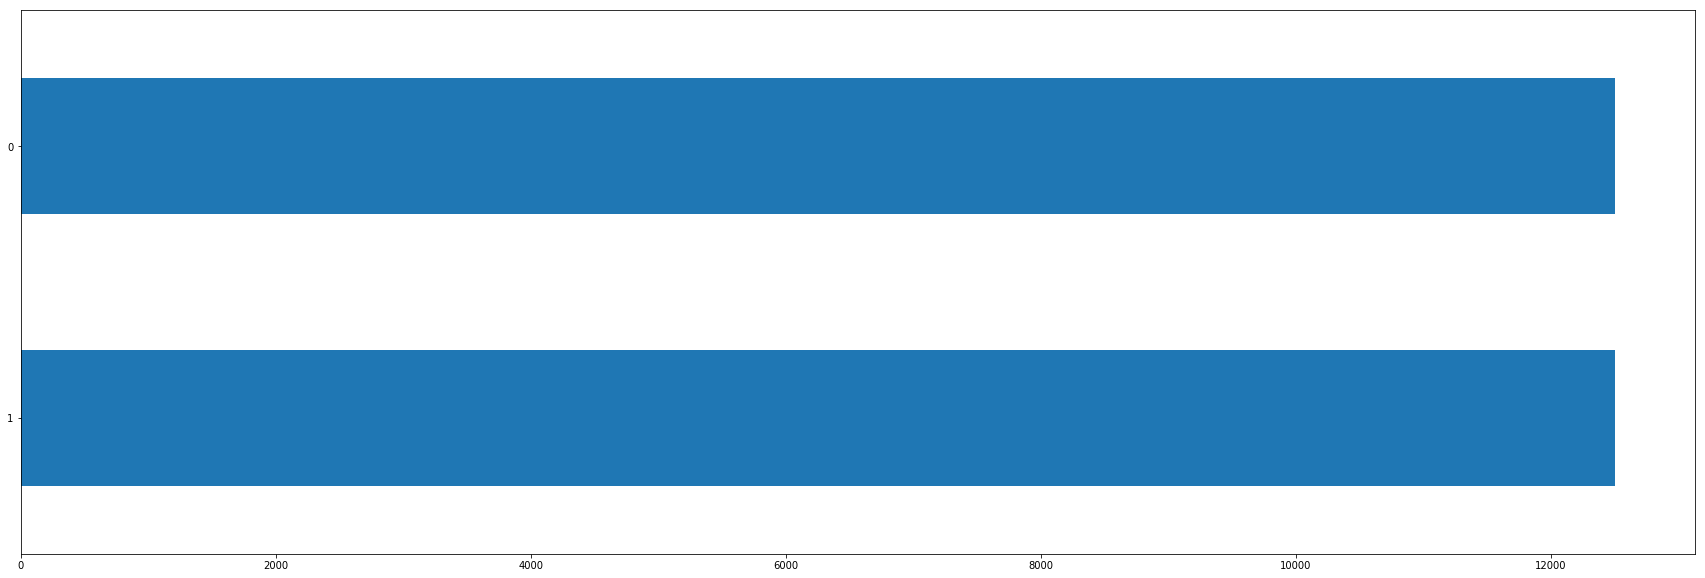

In [41]:
# Is there any class imbalance?
dataset["Label"].value_counts().plot(kind="barh")

In [42]:
# Calculate all sentences individual lengths
sentences_len = [len(sent) for sent in X]

In [43]:
# Maximum size of any particular sentence
max_sentence_size = max(sentences_len)
max_sentence_size

2818

In [44]:
# Minimum size of any particular sentence
min_sentence_size = min(sentences_len)
min_sentence_size

11

In [45]:
# Average size of any particular sentence
avg_sentence_size = reduce((lambda x, y: x + y), sentences_len) // len(X)
avg_sentence_size

282

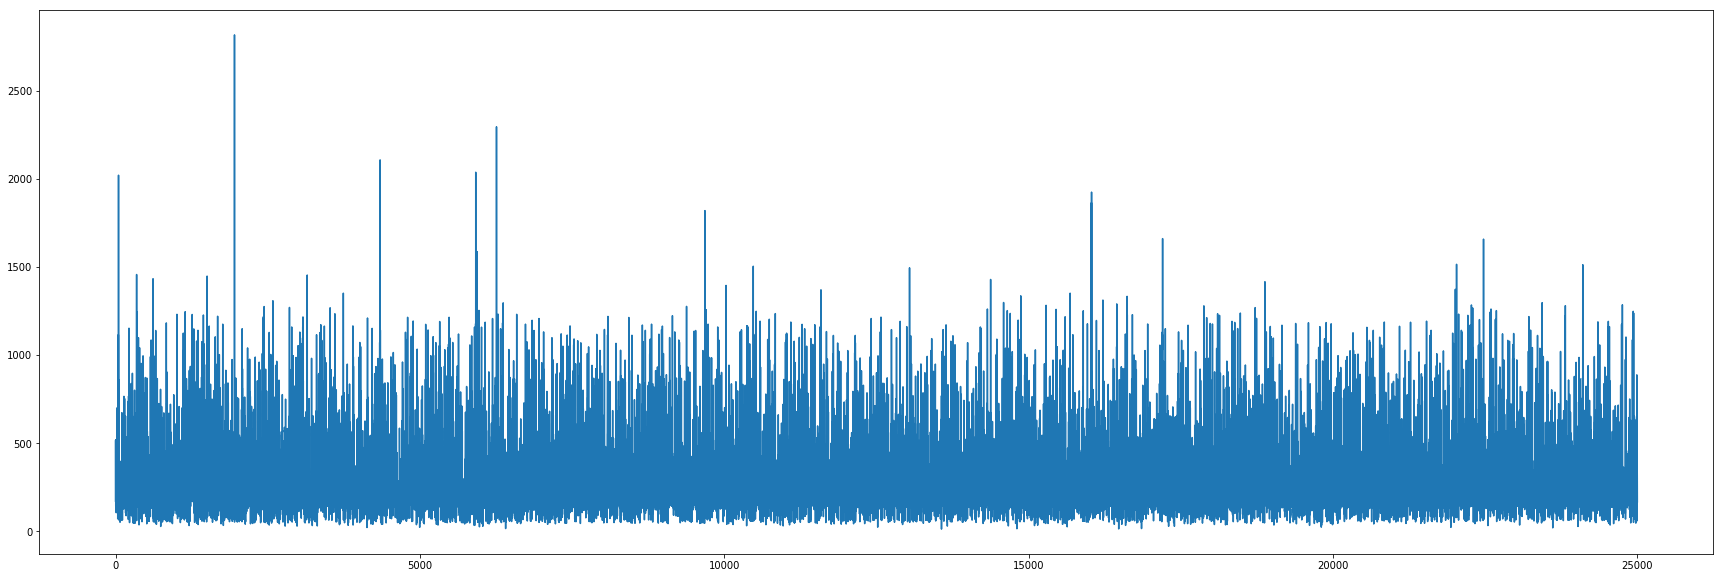

In [46]:
# Let's try to see how length of sentences varies
plt.plot(list(range(len(sentences_len))), sentences_len)

In [47]:
# This function convert sentences array into number array
def num_sentence(sentences_tokens):
    x = [[word2idx.get(word, word2idx.get("UNK")) for word in sent] for sent in sentences_tokens]
    
    return x

In [48]:
X = num_sentence(X)

In [49]:
len(X)

25000

In [50]:
print(X[:2])

[[174943, 152, 14, 7, 7362, 2841, 2, 20, 1421, 22, 0, 215, 79, 19, 77, 68, 1009, 59, 164, 214, 1, 125, 19, 28, 2562, 27, 2, 192, 1678, 82, 6, 0, 3174, 8104, 410, 285, 4, 733, 12, 174943, 152, 9, 15303, 14, 181, 2386, 4, 2532, 73, 14, 28, 2562, 27, 2, 0, 14170, 4, 3981, 7980, 1, 0, 34401, 543, 38, 86, 253, 248, 131, 44, 22495, 2562, 57, 31166, 1, 0, 91887, 3, 0, 1115, 794, 1, 64, 9794, 285, 3, 0, 888, 41, 1522, 5, 44, 543, 2, 61, 41, 822, 0, 1942, 6, 42, 7, 1283, 2648, 977, 4, 6292, 135, 0, 164, 1, 41, 1040, 3151, 434, 434, 434, 22, 434, 434, 434, 2, 152, 2, 7, 2392, 331, 45, 5537, 45, 41, 472, 187, 4, 11739, 48, 3, 392, 2562, 2, 1283, 45, 3143, 4, 174943, 152, 2, 41, 1543, 12, 109, 3574, 3, 192, 464, 269, 12, 174943, 152, 14, 372, 19386, 2, 102, 7, 16214, 12, 20, 14, 70, 805], [26494, 23, 46, 400001, 19, 649, 29594, 2313, 24, 31, 51, 29, 495, 10, 82, 34, 332, 7, 394, 4, 275, 155, 13, 0, 491, 12, 35, 442, 834, 473, 38, 119, 1174, 25, 222, 4, 164, 1, 161, 1, 46, 538, 10, 0, 1120, 2, 96, 

In [51]:
# Perform padding for sentences less then 750
X = pad_sequences(X, maxlen = 750, padding = "pre", truncating = "pre", value = word2idx.get("PAD"))

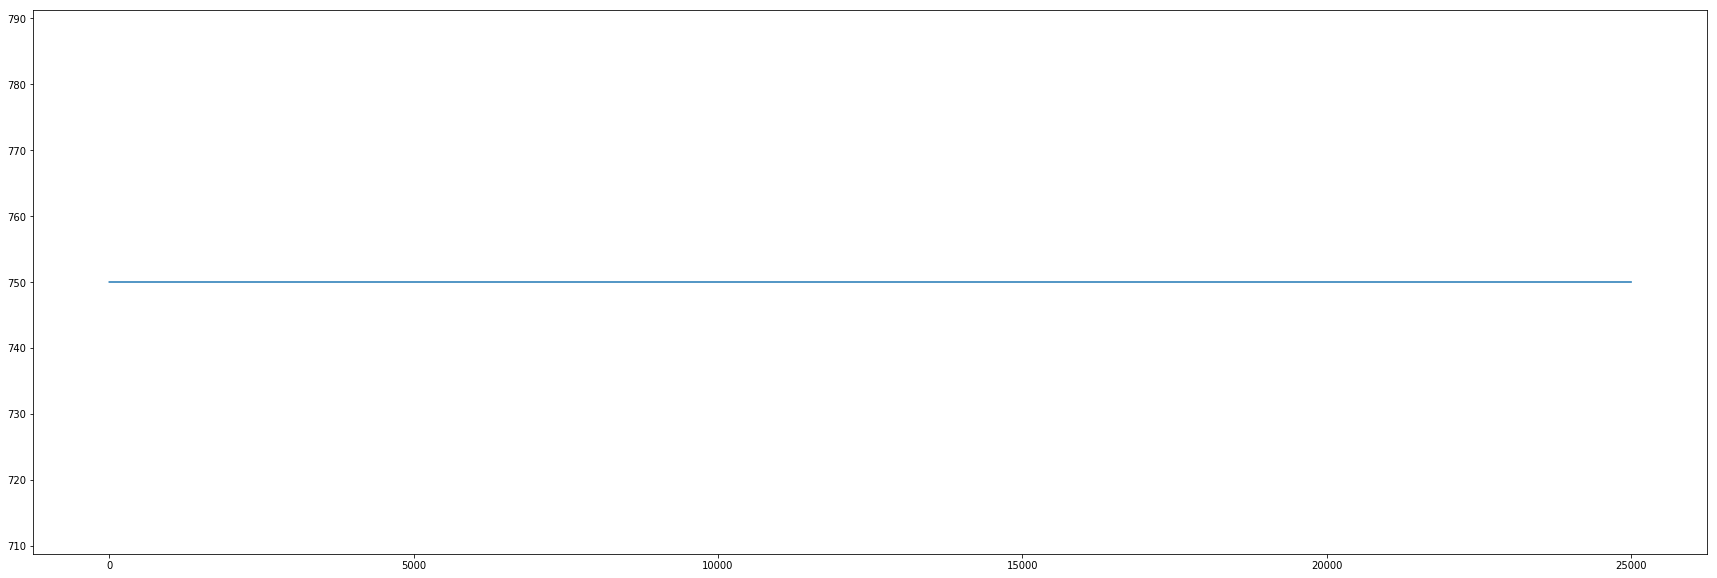

In [52]:
plt.plot(list(range(len(X))), [len(sent) for sent in X])

In [53]:
print(X[:2])

[[400000 400000 400000 ...     14     70    805]
 [400000 400000 400000 ...    275    423      2]]


In [54]:
# let's check our data is in proper shape
X.shape

(25000, 750)

In [55]:
# let's check our data is in proper shape for softmax activation function
Y = np.array(Y)
Y.shape

(25000,)

In [56]:
# Time to convert Y values into one hot encoding
Y = to_categorical(Y)
Y.shape

(25000, 2)

In [57]:
print(Y[:2])

[[0. 1.]
 [0. 1.]]


## Now time to split dataset into train & test data

In [58]:
# Now divide data into training & validations data
train_x, valid_x, train_y, valid_y = train_test_split(X, Y, test_size = 0.10, random_state = 10)

In [59]:
# Model input data dimensions
word_tokens = embedding_matrix.shape[0]
timesteps = 750
data_dim = 100
output_len = 2

In [60]:
# Neural network architecture
model = Sequential()

model.add(Embedding(word_tokens, data_dim, input_shape = (timesteps,), mask_zero = False))

model.add(LSTM(50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(output_len))
model.add(Activation("softmax"))

start = time.time()
model.compile(loss = "categorical_crossentropy", optimizer = "rmsprop", metrics = ['accuracy'])
print ('compilation time : ', time.time() - start)

compilation time :  0.04233074188232422


In [61]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 750, 100)          40000200  
_________________________________________________________________
lstm_1 (LSTM)                (None, 750, 50)           30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 750, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total para

In [62]:
# Now data is in proper format let's fit it
model.fit(train_x, train_y, batch_size = 128, epochs = 1, validation_split = 0.05, verbose = 1)

Train on 21375 samples, validate on 1125 samples
Epoch 1/1
21375/21375 [==============================] - 1001s 47ms/step - loss: 0.4834 - acc: 0.7604 - val_loss: 0.3287 - val_acc: 0.8640
